In [2]:
%matplotlib inline
import numpy as np
from hyperion.model import ModelOutput
import matplotlib.pyplot as plt
from photutils import aperture_photometry as ap
from photutils import CircularAperture
import astropy.constants as const
from astropy.io import ascii
from scipy.interpolate import interp1d

pc = const.pc.cgs.value
c  = const.c.cgs.value
AU = const.au.cgs.value
wl_aper = [3.6, 4.5, 5.8, 8.0, 8.5, 9, 9.7, 10, 10.5, 11, 16, 20, 24, 35, 70, 100, 160, 250, 350, 500, 850]

In [4]:
# read in the model output and set up the pixel scale
# filename = '/Users/yaolun/bhr71/hyperion/cycle6/model47.rtout'
filename = '/home/bettyjo/yaolun/hyperion/bhr71/cycle6/model47/model47.rtout'
m = ModelOutput(filename)
im = m.get_image(group=len(wl_aper)+1, inclination=0, distance=178.*pc, units='MJy/sr')
w = np.degrees((1.5*pc)/im.distance)*60
pix_num = len(im.val[:,0,0])
pix2arcsec = 2*w/pix_num
# convert the flux units into Jy/pix
im.val = im.val*1e6/4.25e10*pix2arcsec**2

In [5]:
# set up the aperture for given wavelength
aper = np.empty_like(wl_aper)
for i in range(0, len(wl_aper)):
    if wl_aper[i] <= 20:
        aper[i] = 7.2 * wl_aper[i]/10.
    elif (wl_aper[i] > 20) & (wl_aper[i] <=50):
        aper[i] = 7.2 * 2
    else:
        aper[i] = 24.5

# set up resolution averaging window
res = np.empty_like(wl_aper)
for i in range(0, len(wl_aper)):
    if (wl_aper[i] < 50.) & (wl_aper[i] >= 5):
        res[i] = 600.
    elif wl_aper[i] < 5:
        res[i] = 10.
    else:
        res[i] = 1000.

phot = np.empty_like(wl_aper)
for i in range(len(wl_aper)):
    apertures = CircularAperture((pix_num/2.-1,pix_num/2.-1), r=aper[i]/pix2arcsec)
#     apertures = CircularAperture((pix_num/2.-1,pix_num/2.-1), r=w/pix2arcsec)
    wav = wl_aper[i]
    iwav = np.argmin(np.abs(wav - im.wav))
    if len(np.where((im.wav < wl_aper[i]*(1+1./res[i])) & (im.wav > wl_aper[i]*(1-1./res[i])))[0]) != 0:
        im_avg = np.mean(im.val[:,:,(im.wav < wl_aper[i]*(1+1./res[i])) & (im.wav > wl_aper[i]*(1-1./res[i]))],axis=2)
    else:
        im_avg = im.val[:,:,iwav]
    phot_table = ap(im_avg, apertures)
    phot[i] = phot_table['aperture_sum'].data[0]*c/wav*1e4*1e-23

In [6]:
# read in the sed_w_aperture.txt
# sed_w_aper = ascii.read('/Users/yaolun/bhr71/hyperion/cycle6/model47_sed_w_aperture.txt')
sed_w_aper = ascii.read('/home/bettyjo/yaolun/hyperion/bhr71/cycle6/model47/model47_sed_w_aperture.txt')

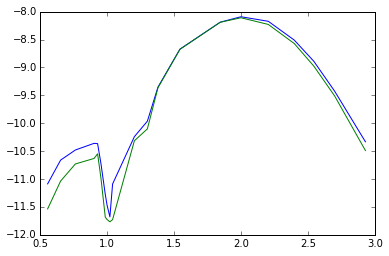

In [7]:
plt.plot(np.log10(wl_aper), np.log10(phot/0.26590687))
plt.plot(np.log10(sed_w_aper['wave']), np.log10(sed_w_aper['vSv']))
# print np.log10(phot/0.26590687)/np.log10(sed_w_aper['vSv'])

In [8]:
sed_inf = m.get_sed(group=0, inclination=0, aperture=-1, distance=178.0 * pc)
# get flux at different apertures
flux_aper = np.empty_like(wl_aper)
unc_aper = np.empty_like(wl_aper)
for i in range(0, len(wl_aper)):
    sed_dum = m.get_sed(group=i+1, inclination=0, aperture=-1, distance=178.0 * pc)
    # use a rectangle function the average the simulated SED
    # apply the spectral resolution
    if (wl_aper[i] < 50.) & (wl_aper[i] >= 5):
        res = 600.
    elif wl_aper[i] < 5:
        res = 10.
    else:
        res = 1000.
    ind = np.where((sed_dum.wav < wl_aper[i]*(1+1./res)) & (sed_dum.wav > wl_aper[i]*(1-1./res)))
    if len(ind[0]) != 0:
        flux_aper[i] = np.mean(sed_dum.val[ind])
    else:
        f = interp1d(sed_dum.wav, sed_dum.val)
        flux_aper[i] = f(wl_aper[i])
    print wl_aper[i], flux_aper[i]

3.6 3.12920284855e-12
4.5 9.40877876679e-12
5.8 1.2833057759e-11
8.0 3.13575513858e-11
8.5 2.94696634549e-11
9 1.12976816438e-11
9.7 2.77478811641e-12
10 6.53481350636e-13
10.5 3.8554982907e-13
11 1.19163136541e-12
16 4.9165547377e-11
20 7.64991874314e-11
24 4.34557355946e-10
35 2.10698104797e-09
70 6.41247612445e-09
100 7.8124359634e-09
160 6.0704612921e-09
250 2.58367264098e-09
350 1.01139070585e-09
500 2.81516251046e-10
850 3.25832382904e-11


##test method in infinite aperture image vs sed

In [9]:
# read in the model output and set up the pixel scale
# filename = '/Users/yaolun/bhr71/hyperion/cycle6/model47.rtout'
filename = '/home/bettyjo/yaolun/hyperion/bhr71/cycle6/model47/model47.rtout'
m = ModelOutput(filename)
im = m.get_image(group=len(wl_aper)+1, inclination=0, distance=178.*pc, units='MJy/sr')
w = np.degrees((1.5*pc)/im.distance)*60
pix_num = len(im.val[:,0,0])
pix2arcsec = 2*w/pix_num
print w
# sum over the field of view
im_avg_1d = np.sum(im.val, axis=(0,1)) * 1e6/4.25451703e10*pix2arcsec**2*1e-23 * c/im.wav*1e4

# read in the SED 
sed_inf = m.get_sed(group=0, inclination=0, aperture=-1, distance=178.0*pc)

28.9697761583


[ 0.26590687  0.26590687  0.26590687 ...,  0.26590687  0.26590687
  0.26590687]


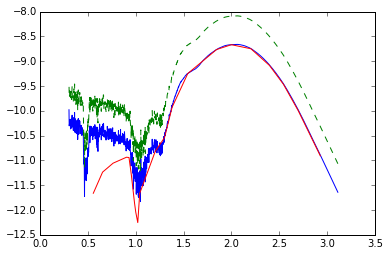

In [10]:
plt.plot(np.log10(im.wav), np.log10(im_avg_1d))
plt.plot(np.log10(sed_inf.wav), np.log10(sed_inf.val),'--')
plt.plot(np.log10(wl_aper), np.log10(phot))
print im_avg_1d/sed_inf.val

##Compare the result against RADMC-3D

Model15 in cycle7 and hyperion_apertest in radmc_simulation

In [11]:
hyperion_w_aper = ascii.read('/home/bettyjo/yaolun/hyperion/bhr71/model15/model15_sed_w_aperture.txt')

In [26]:
print hyperion_w_aper

 wave     vSv    
----- -----------
  3.6 5.80304e-12
  4.5 1.20487e-11
  5.8 1.66404e-11
  8.0 1.76792e-11
  8.5 2.08603e-11
  9.0 7.30962e-12
  9.7 6.04548e-13
 10.0  5.1964e-13
 10.5 5.96409e-13
 11.0 5.63297e-13
 16.0 4.19228e-11
 20.0 7.08759e-11
 24.0 3.86041e-10
 35.0 1.95396e-09
 70.0 5.71944e-09
100.0 6.54021e-09
160.0 4.62533e-09
250.0 1.96331e-09
350.0 7.34656e-10
500.0 2.06403e-10
850.0 2.04962e-11


In [28]:
radmc_w_aper = ascii.read('/home/bettyjo/yaolun/radmc_simulation/bhr71/hyperion_apertest/spectrum.out',data_start=2, header_start=None, names=['wave','flux'])
# flux unit: erg cm-2 s-1 Hz-1
radmc_w_aper['vSv'] = radmc_w_aper['flux'] * c/radmc_w_aper['wave']/1e-4/178**2

/home/bettyjo/yaolun/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


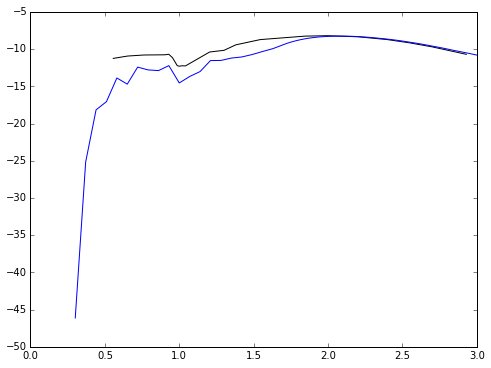

In [29]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(np.log10(hyperion_w_aper['wave']), np.log10(hyperion_w_aper['vSv']), color='k')
ax.plot(np.log10(radmc_w_aper['wave']), np.log10(radmc_w_aper['vSv']), color='b')